# Прогнозирование количества заказов такси

Компания "Чётенькое такси" собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

**Цель проекта** построить модель для такого предсказания. Для этого нам предоставлены данные в виде таблицы из двух столбцов – столбец со временем `datetime` и столбец с количеством заказов такси `num_orders`. Критерием хорошей работы модели является значение `RMSE` на *тестовой выборке* меньше **48**.

Проект будет проходить в несколько **этапов**:
<p><b>1</b> Подготовка и исследовательский анализ данных
<p>&nbsp;&nbsp;&nbsp;&nbsp; <b>1.1</b> Подготовка данных
<br>&nbsp;&nbsp;&nbsp;&nbsp; <b>1.2</b> Исследовательский анализ данных
<p><b>2</b> Построение и обучение моделей
<p>&nbsp;&nbsp;&nbsp;&nbsp; <b>2.1</b>  Создание признаков
<br>&nbsp;&nbsp;&nbsp;&nbsp; <b>2.2</b>  Построение и обучение моделей
<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>2.2.1</b>  <i>Линейная регрессия</i>
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>2.2.2</b>  <i>Cлучайный лес</i>
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>2.2.3</b>  <i>Градиентный бустинг</i>
<p> <b>3</b> Выбор и тестирование лучшей модели
<p>&nbsp;&nbsp;&nbsp;&nbsp; <b>3.1</b> Выбор лучшей модели и сравнение с <i>моделью Хольта-Винтерса</i>
<br>&nbsp;&nbsp;&nbsp;&nbsp; <b>3.2</b> Тестирование лучшей модели
<p> <b>5</b> Выводы

## Подготовка и исследовательский анализ данных

### Подготовка данных

In [1]:
# импорт библиотек
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor

In [2]:
# чтение файла с данными и его сохранение в таблице
try:
    df = pd.read_csv('taxi.csv', index_col=['datetime'], parse_dates=['datetime'])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=['datetime'], parse_dates=['datetime'])

In [3]:
# вывод 5 первых строк таблицы 
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# вывод общей информации
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


При чтении файла мы установили в качестве индекса столбец `datetime`, изменив его тип данных на `datetime`. Отметим, что пропусков в данных не было.

Проверим индекс на монотонность.

In [5]:
# проверка индекса на монотонность
df.index.is_monotonic

True

Временной ряд упорядочен.

Также стоит отметить, что нам предоставлены данные о количестве заказов такси за каждые 10 мин, начиная с `2018-03-01 00:00:00` до `2018-08-31 23:50:00`. Будущие модели будут делать прогноз только на следующий час. Поэтому ресемплируем данные по одному часу.

In [6]:
# ресемплирование данных по одному часу
df = df.resample('1H').sum()

### Исследовательский анализ данных 

Выведем два графика. На одном представим весь временной ряд, а на втором только за первую неделю мая. На обоих графиках изобразим также скользящее среднее, учитывающее последние 24 часа.

Text(0.5, 0.95, 'Зависимость количества заказов такси от времени')

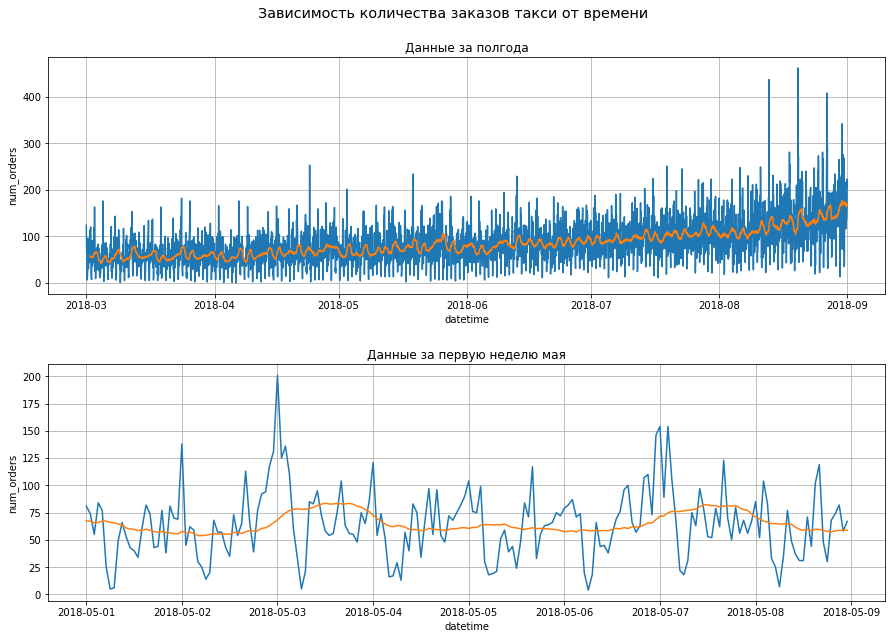

In [7]:
# вывод временного ряда в виде графика
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

sns.lineplot(x=df.index, y='num_orders', ax=axs[0], data=df)
axs[0].plot(df.rolling(24).mean())
axs[0].set_title('Данные за полгода')
axs[0].grid()

sns.lineplot(x=df.loc['2018-05-01':'2018-05-08'].index, y='num_orders', ax=axs[1], data=df.loc['2018-05-01':'2018-05-08'])
axs[1].plot(df.rolling(24).mean().loc['2018-05-01':'2018-05-08'])
axs[1].set_title('Данные за первую неделю мая')
axs[1].grid()

plt.subplots_adjust(hspace=0.3)
fig.suptitle('Зависимость количества заказов такси от времени', fontsize='x-large', y=0.95)

Данные за полгода демонстрируют, что со временем заказов такси становится больше. На втором графике можно увидеть множество пиков, среди которых можно выделить группу, относящуюся к заказам в **полночь**.

Для более удобного рассмотрения воспользуемся классом `seasonal_decompose` из модуля `statsmodels.tsa.seasonal`. Разобьем данные на тренд, сезонность и шум. График сезонности изобразим в масштабе трех дней.

In [8]:
# создание временной таблицы
temp_df = df.copy()

In [9]:
# поиск тренда, сезонности и шума
decomposed = seasonal_decompose(temp_df)
temp_df['trend'] = decomposed.trend
temp_df['seasonal'] = decomposed.seasonal
temp_df['resid'] = decomposed.resid

Text(0.5, 0.95, 'Разбиение временного ряда на тренд, сезонность и шум')

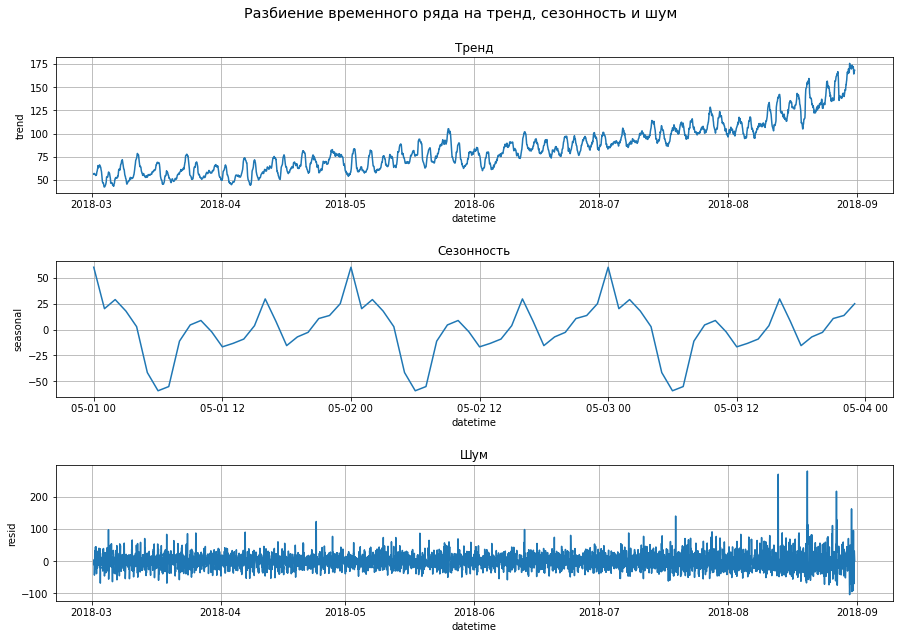

In [10]:
# вывод тренда, сезонности и шума в виде графиков
fig, axs = plt.subplots(3, 1, figsize=(15, 10))

sns.lineplot(x=temp_df.index, y='trend', ax=axs[0], data=temp_df)
axs[0].set_title('Тренд')
axs[0].grid()

sns.lineplot(x=temp_df.loc['2018-05-01':'2018-05-03', :].index, y='seasonal',
             ax=axs[1], data=temp_df.loc['2018-05-01 ':'2018-05-03', :])
axs[1].set_title('Сезонность')
axs[1].grid()

sns.lineplot(x=temp_df.index, y='resid', ax=axs[2], data=temp_df)
axs[2].set_title('Шум')
axs[2].grid()

plt.subplots_adjust(hspace=0.5)
fig.suptitle('Разбиение временного ряда на тренд, сезонность и шум', fontsize='x-large', y=0.95)

Мы видим, что в течении полугода востребованность в "четеньких" такси и правда растет. График сезонности показывает, что наблюдается суточная сезонность. В течении одного дня можно выделить три пика: **00:00**, **11:00** и **17:00**. В это время такси наиболее востребовано. Мы также видим шум, который по масштабам часто превосходит сезонность.

Скорее всего существует не только суточная сезонность, но и недельная. Чтобы это увидеть ресемплируем временной ряд по одному дню. Снова разобьем данные на тренд, сезонность и шум. График сезонности изобразим в масштабах трех недель.

In [11]:
# создание временной таблицы
temp_df = df.copy()
temp_df = temp_df.resample('1D').sum()
temp_df = temp_df.dropna()

In [12]:
# поиск тренда, сезонности и шума
decomposed = seasonal_decompose(temp_df)
temp_df['trend'] = decomposed.trend
temp_df['seasonal'] = decomposed.seasonal
temp_df['resid'] = decomposed.resid
temp_df['day_of_week'] = [f'{day.day_name()}_{i // 7}' for i, day in enumerate (temp_df.index)]

Text(0.5, 0.95, 'Разбиение временного ряда на тренд, сезонность и шум')

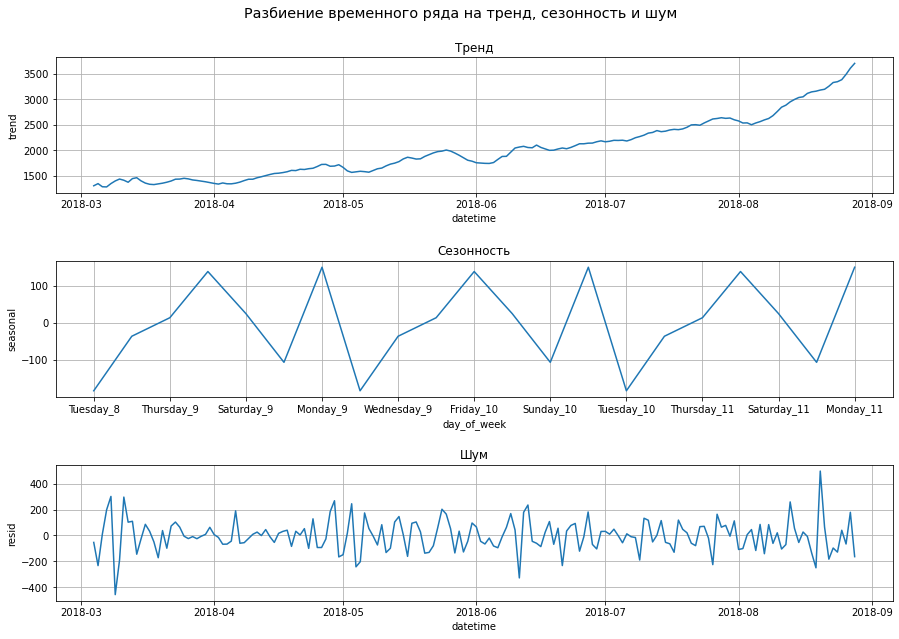

In [13]:
# вывод тренда, сезонности и шума в виде графиков
fig, axs = plt.subplots(3, 1, figsize=(15, 10))

sns.lineplot(x=temp_df.index, y='trend', ax=axs[0], data=temp_df)
axs[0].set_title('Тренд')
axs[0].grid()

sns.lineplot(x=temp_df.loc['2018-05-01':'2018-05-21', 'day_of_week'], y='seasonal',
             ax=axs[1], data=temp_df.loc['2018-05-01':'2018-05-21', :])
axs[1].set_xticks(temp_df.loc['2018-05-01':'2018-05-21', 'day_of_week'][::2])
axs[1].set_title('Сезонность')
axs[1].grid()

sns.lineplot(x=temp_df.index, y='resid', ax=axs[2], data=temp_df)
axs[2].set_title('Шум')
axs[2].grid()

plt.subplots_adjust(hspace=0.5)
fig.suptitle('Разбиение временного ряда на тренд, сезонность и шум', fontsize='x-large', y=0.95)

Тренд и шум не подверглись большим изменениям. Зато сезонность теперь недельная. Пики приходятся на **понедельник** и **пятницу**. Это можно объяснить тем, что первая группа людей предпочитают прилетать накануне рабочей недели, вторая в ее конце, чтобы отдохнуть пару дней перед работой.

## Построение и обучение моделей

### Создание признаков

Перейдем к созданию признаков. Напишем специальную функцию `make_features`, которая добавит *календарные признаки*: час, день недели и информацию о том, является ли день выходным или нет; *скользящее среднее*, сдвинутое на один час, и несколько *отстающих значений*.

In [14]:
# создание функции, генерирующей признаки
def make_features(data, max_lag, rolling_mean_size):
    
    new_data = data.copy()

    new_data['hour'] = new_data.index.hour
    new_data['day_of_week'] = new_data.index.dayofweek
    new_data['is_weekend'] = new_data['day_of_week'].isin([5,6]).astype('int')
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return new_data

Учесть сезонность помогут *календарные признаки*: `hour`, `day_of_week` и `is_weekend`. А отследить тренд — `rolling_mean` и `lag_...`. 

Будем считать, что для прогноза моделям достаточно информации за последние 3 дня. Создадим признаки, задав для функции `make_features` следующие параметры: `max_lag` = **72**, `rolling_mean_size` = **72**.

In [15]:
# добавление признаков
new_df = make_features(df, 72, 72)
new_df = new_df.dropna()

### Построение и обучение моделей

Мы обучим 3 вида моделей: *линейную регрессию*, *случаный лес* и ансамбль *решающих деревьев*, построенный с помощью *градиентного бустинга*.

Выделим *обучающие* и *целевой признаки*.

In [16]:
# выделение признаков
features = new_df.drop(columns='num_orders')
target = new_df['num_orders']

#### Линейная регрессия

Преоброзуем категориальные признаки техникой *One-Hot Encoding*. За категориальные признаки примем час, день недели и информацию о том, является ли день выходным.

In [17]:
# преобразование категориальных признаков
cat_features = ['hour', 'day_of_week', 'is_weekend']
ohe_features = pd.get_dummies(features, columns=cat_features, drop_first=True)

Разделим временной ряд на *обучающую* и *тестовую выборки* в соотношении **9:1**. Стандартизируем количественные признаки.

In [18]:
# разделение временного ряда на выборки
ohe_train_features, ohe_test_features, ohe_train_target, ohe_test_target = train_test_split(ohe_features,
                                                                                            target,
                                                                                            test_size=0.1,
                                                                                            shuffle=False)

In [19]:
# стандартизация количественных признаков
pd.options.mode.chained_assignment = None

quantitative = features.drop(columns=cat_features).columns

scaler = StandardScaler()
scaler.fit(ohe_train_features[quantitative])
ohe_train_features[quantitative] = scaler.transform(ohe_train_features[quantitative])
ohe_test_features[quantitative] = scaler.transform(ohe_test_features[quantitative])

Визуализируем разделение выборок.

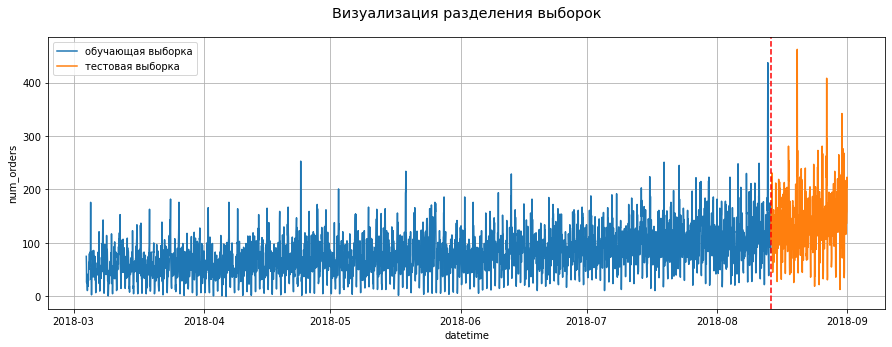

In [20]:
# визуализация разделения выборок
fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(ax=ax, data=ohe_train_target, label='обучающая выборка')
sns.lineplot(ax=ax, data=ohe_test_target, label='тестовая выборка')

ax.axvline(ohe_train_target.index[-1], c='r', ls='--', lw=1.5)

ax.set_title('Визуализация разделения выборок', fontsize='x-large', y=1.05)

ax.legend()

ax.grid()

Обучим модели *линейной регрессии* с помощью класса `GridSearchCV` библиотеки `sklearn`.

In [21]:
%%time
# обучение моделей линейной регрессии
param_grid = {}

tscv = TimeSeriesSplit(n_splits=9)

linear_regression = GridSearchCV(LinearRegression(), param_grid, scoring='neg_root_mean_squared_error', n_jobs=6, cv=tscv)
linear_regression.fit(ohe_train_features, ohe_train_target)

CPU times: total: 15.6 ms
Wall time: 1.98 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=9, test_size=None),
             estimator=LinearRegression(), n_jobs=6, param_grid={},
             scoring='neg_root_mean_squared_error')

#### Cлучайный лес

В отличие от *линейной регрессии*, в данном случае преобразовывать категориальные признаки не нужно, все они представлены числами. Мы можем сразу разделить временной ряд на выборки и стандартизировать количественные признаки.

In [22]:
# разделение данных на выборки
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.1, shuffle=False)

In [23]:
# стандартизация количественных признаков
pd.options.mode.chained_assignment = None

quantitative = features.drop(columns=cat_features).columns

scaler = StandardScaler()
scaler.fit(train_features[quantitative])
train_features[quantitative] = scaler.transform(train_features[quantitative])
test_features[quantitative] = scaler.transform(test_features[quantitative])

С помощью класса `GridSearchCV` проведем кросс-валидационный поиск лучшей модели *случайного леса*. Изменяемыми параметрами будут:

* `n_estimator` в предалах от **1** до **16** с шагом **2** 
* `max_depth` в пределах от **1** до **32** с шагом **2**.

In [24]:
%%time
# обучение моделей случайного леса
n_estimator_array = np.arange(1, 16, 2)
max_depth_array = np.arange(1, 32, 2)
param_grid = {'n_estimators': n_estimator_array, 'max_depth': max_depth_array}
random_forest = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, scoring='neg_root_mean_squared_error', n_jobs=6, cv=tscv)
random_forest.fit(train_features, train_target)

CPU times: total: 2.31 s
Wall time: 1min 19s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=9, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=6,
             param_grid={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]),
                         'n_estimators': array([ 1,  3,  5,  7,  9, 11, 13, 15])},
             scoring='neg_root_mean_squared_error')

#### Градиентный бустинг

Построим ансамбль *решающих деревьев*, обученный с помощью *градиентного бустинга*. Воспользумеся библиотекой `catboost`. *Обучающая* и *тестовая выборки* такие же, как и у модели *случайного леса*. В качестве изменяющихся параметров для `GridSearchCV` возьмем:

* `depth` в пределах от **2** до **5**
* `learning_rate` в пределах от **0.01** до **0.1** с шагом **0.02**

Количество деревьев `iterations` зададим равным **1000**.

In [25]:
%%time
# обучение градиентным бустингом
learning_rate = np.arange(0.01, 0.1, 0.02)
depth = np.arange(2, 6)

param_grid = {'learning_rate': learning_rate, 'depth': depth}

gradient_boosting = GridSearchCV(CatBoostRegressor(iterations=1000, loss_function='RMSE', random_seed=42, verbose=False, cat_features=cat_features),
                                 param_grid, scoring='neg_root_mean_squared_error', n_jobs=6, cv=tscv)

gradient_boosting.fit(train_features, train_target)

CPU times: total: 10.1 s
Wall time: 11min 24s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=9, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x000001E609428730>,
             n_jobs=6,
             param_grid={'depth': array([2, 3, 4, 5]),
                         'learning_rate': array([0.01, 0.03, 0.05, 0.07, 0.09])},
             scoring='neg_root_mean_squared_error')

## Выбор и тестирование лучшей модели

### Выбор лучшей модели и сравнение с моделью Хольта-Винтерса

Выведем сводную таблицу с параметрами и метриками качества наилучших моделей каждого типа.

In [26]:
# вывод сводной таблицы
rmse_array = [abs(linear_regression.best_score_), abs(random_forest.best_score_),
              abs(gradient_boosting.best_score_)]

max_depth_array = ['', random_forest.best_params_['max_depth'], gradient_boosting.best_params_['depth']]

n_estimators_array = ['', random_forest.best_params_['n_estimators'], 1000]

learning_rate = ['', '', gradient_boosting.best_params_['learning_rate']]

table = {'RMSE': rmse_array, 'max_depth': max_depth_array, 'n_estimators/iterations': n_estimators_array,
         'learning_rate': learning_rate}

df_table = pd.DataFrame(data=table, index=['linear regression', 'random forest', 'gradient boosting'])

df_table.index.name = 'model'

df_table

,RMSE,max_depth,n_estimators/iterations,learning_rate
model,,,,
linear regression,23.770417,,,
random forest,24.289916,9,15,
gradient boosting,22.305475,5,1000,0.03


Как мы видим, наименьшего `RMSE` равного **22.3** удалось достичь модели *градиентного бустинга* . Модель *линейной регрессии* показала `RMSE` равное **24.3**, модель *случайного леса* — **23.8**.

Параметры итоговой модели *градиентного бустинга* следующие: `iterations` = **1000**, `depth` = **5**, `learning_rate` = **0.03**. Меньшие значения `learning_rate` недоучивают модель при заданном `iterations`, большие — не могут достаточно близко привести модель к оптимальному решению. 

Было бы здорово сравнить полученные результаты с работой модели, напрямую работающей с временными рядами, например, с *моделью Хольта-Винтерса*. Проверим качество данной модели на *обучающей выборке*. Хотя модель способна предсказывать на $m$ шагов вперед, мы обучим модель предсказывать *целевой признак* только на следующий час.

Для обучения будем использовать информацию за прошедшие 3 недели, так как на данном промежутке уже прослеживается тренд.

In [27]:
%%time
# обучение модели Хольта-Винтерса
train, test = train_test_split(df['num_orders'], test_size=0.1, shuffle=False)

rmse_list = []

for train_index, test_index in tscv.split(train):

    for i in range(test_index.shape[0]):
        
        exponential_smoothing = ExponentialSmoothing(train[train_index+i].tail(504), trend='add', seasonal='add').fit()
        
        if i == 0:
            exponential_smoothing_predicted = exponential_smoothing.forecast(1)
        else:
            exponential_smoothing_predicted = pd.concat([exponential_smoothing_predicted, exponential_smoothing.forecast(1)])
        
    rmse_list.append(mean_squared_error(train[test_index], exponential_smoothing_predicted) ** 0.5)

CPU times: total: 8min 11s
Wall time: 8min 12s


Выведем результат работы *модели Хольта-Винтерса* на *обучающей выборке*.

In [28]:
# вывод RMSE для модели Хольта-Винтерса
df_table = pd.DataFrame(data={'RMSE': sum(rmse_list) / len(rmse_list)}, index=['Holt Winters'])

df_table.index.name = 'model'

df_table

,RMSE
model,
Holt Winters,22.436845


Получилось *RMSE* сравнимое c тем, что показал ансамбль *решающих деревьев*, обученных методом *градинетного бустинга*. В качестве рабочей модели оставим модель с лучшим *RMSE*.

### Тестирование лучшей модели

Выведем *RMSE* модели *градиентного бустинга* на *тестовой выборке*.

In [29]:
# вывод RMSE для модели градиентного бустинга
df_table = pd.DataFrame(data={'RMSE': mean_squared_error(test_target, gradient_boosting.predict(test_features)) ** 0.5}, index=['gradient boosting'])

df_table.index.name = 'model'

df_table

,RMSE
model,
gradient boosting,37.805338


*RMSE* на *тестовой выборке* оказалось равным **37.8**. Представим в виде графика результаты прогноза.

In [30]:
# создание таблицы с целевыми значениями и предсказаниями
temp_frame = pd.concat([test_target,
                        pd.DataFrame(gradient_boosting.predict(test_features), index=test_features.index)], axis=1)

temp_frame.columns = ['true', 'predicted']

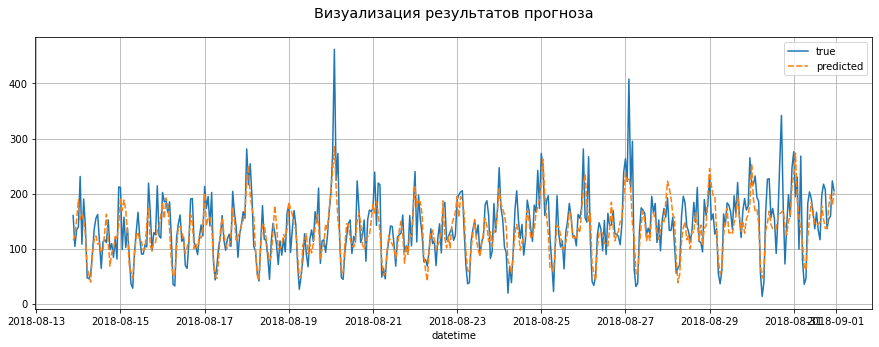

In [31]:
# вывод результатов прогноза
fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(ax=ax, data=temp_frame)

ax.set_title('Визуализация результатов прогноза', fontsize='x-large', y=1.05)

ax.legend()

ax.grid()

Как мы видим, модель *градиентного бустинга*, успешно отмечает пики, связанные с сезонностью. Однако в случае аномально высокого спроса количество, предсказанных моделью заказов, может быть вполовину меньше истинных значений. В будущем это может привести к тому, что в аномальные часы, в аэропортах будет большой недостаток свободных машин.

## Выводы

Итак, мы рассмотрели временной ряд, отметив тренд к повышению запроса на "четенькие такси", суточную и недельную сезонность.

Создали необходимые для обучения классических моделей признаки. Обучили модели *линейной регрессии* и *случайного леса* и ансамбль *решающих деревьев*, обученных методом *градинетного бустинга*. Сравнили работу классических моделей и *модели Хольта-Винтерса* между собой. Как оказалось, наилучший результат на *обучающей выборке* показала модель *градиентного бустинга* — **22.3**, на втором месте — *модель Хольта-Винтерса* с *RMSE* равным **22.4**. 

В качестве финальной модели был выбран ансамбль *решающих деревьев*, обученный методом *градиентного бустинга*. На *тестовой выборке* ему удалось достигнуть *RMSE* равное **37.8**. Как оказалось, модель хорошо предсказывает пиковые часы запросов, но не всегда прогнозирует в эти часы необходимое количество машин.